In [1]:
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm
from collections import defaultdict
from scipy import spatial
from IPython.display import HTML, display
import tabulate
import json
import pickle
import re
import nltk

# Dataset Prep

In [30]:
df = pd.read_excel("InputTestSet-Reviews48_Ann.xlsx")

In [31]:
df.head()

,UID,PID,Dec,Sent,MComp,Cat,SubCat
0,0,2019_SJf_XhCqKm,Reject,The authors propose to use k-DPP to select a s...,0,NaN,NaN
1,1,2019_SJf_XhCqKm,Reject,"This paper covers the related work nicely, wit...",0,NaN,NaN
2,2,2019_SJf_XhCqKm,Reject,The rest of the paper are also clearly written.,0,NaN,NaN
3,3,2019_SJf_XhCqKm,Reject,"However, I have some concerns about the propos...",0,NaN,NaN
4,4,2019_SJf_XhCqKm,Reject,"- It is not clear how to define the kernel, th...",0,NaN,NaN


In [32]:
df.shape

(1505, 7)

In [33]:
gt_dict = {}

for i in range(0, df.shape[0]):
    pid = df.loc[i]["PID"]
    if not pid in gt_dict:
        gt_dict[pid] = {"dec": df.loc[i]["Dec"], "mcomp": set(), "not_mcomp": set()}
    if df.loc[i]["MComp"] == 1:
        gt_dict[pid]["mcomp"].add(df.loc[i]["UID"])
    else:
        gt_dict[pid]["not_mcomp"].add(df.loc[i]["UID"])

In [34]:
stats_dict = {"Accept": [0, 0], "Reject": [0, 0]}

for k, v in gt_dict.items():
    #print(len(v["mcomp"]), len(v["not_mcomp"]), v["dec"])
    stats_dict[v["dec"]][0] += len(v["mcomp"])
    stats_dict[v["dec"]][1] += len(v["not_mcomp"])
    
print(stats_dict)

{'Accept': [48, 644], 'Reject': [69, 744]}


In [35]:
test_set = list(gt_dict.keys())
print("TestSet length: %d\n"%len(test_set), test_set)

TestSet length: 32
 ['2019_SJf_XhCqKm', '2017_Bk0MRI5lg', '2020_SyevYxHtDB', '2018_rJBiunlAW', '2020_rkltE0VKwH', '2018_Hki-ZlbA-', '2019_BJx0sjC5FX', '2020_r1e_FpNFDr', '2020_B1lsXREYvr', '2018_SkZxCk-0Z', '2019_rJzoujRct7', '2018_HkfXMz-Ab', '2017_BJ9fZNqle', '2019_SyxZJn05YX', '2017_B1ckMDqlg', '2017_HJ0NvFzxl', '2017_S1_pAu9xl', '2018_SyYYPdg0-', '2017_BJAA4wKxg', '2019_HyVxPsC9tm', '2019_HylTBhA5tQ', '2019_B1l08oAct7', '2018_H135uzZ0-', '2017_H1oyRlYgg', '2017_r1y1aawlg', '2020_r1eX1yrKwB', '2020_Byg79h4tvB', '2019_H1lFZnR5YX', '2020_BkeWw6VFwr', '2018_HyHmGyZCZ', '2018_HyUNwulC-', '2020_HkgsPhNYPS']


In [36]:
for k in test_set:
    print('{:20}{}'.format(k, gt_dict[k]["mcomp"]))

2019_SJf_XhCqKm     {39, 17, 20, 27, 28, 30}
2017_Bk0MRI5lg      {48, 57}
2020_SyevYxHtDB     {76, 87}
2018_rJBiunlAW      {108, 110, 112, 113, 124, 126}
2020_rkltE0VKwH     {160, 155, 184, 159}
2018_Hki-ZlbA-      {267, 235, 236, 271}
2019_BJx0sjC5FX     {292, 287}
2020_r1e_FpNFDr     {312, 322, 315, 308}
2020_B1lsXREYvr     {376, 401}
2018_SkZxCk-0Z      {449, 443, 445, 486}
2019_rJzoujRct7     {518, 519}
2018_HkfXMz-Ab      {573, 566}
2017_BJ9fZNqle      {627, 623, 615}
2019_SyxZJn05YX     {672, 673, 657, 669, 671}
2017_B1ckMDqlg      {714, 707}
2017_HJ0NvFzxl      {739}
2017_S1_pAu9xl      {792, 809, 810, 806}
2018_SyYYPdg0-      {834, 867, 868, 869, 870, 872, 873, 844, 830}
2017_BJAA4wKxg      {884}
2019_HyVxPsC9tm     {931, 933, 905, 909, 912, 913, 919, 926}
2019_HylTBhA5tQ     {972, 950}
2019_B1l08oAct7     {994, 996, 1064, 1004, 1007, 1044, 1047, 1048, 1055}
2018_H135uzZ0-      {1072, 1079}
2017_H1oyRlYgg      set()
2017_r1y1aawlg      {1125, 1162, 1100, 1102, 1168}
2020_r1eX1y

In [37]:
sents_for_test = defaultdict(list)

for i in range(0, df.shape[0]):
    pid = df.loc[i]["PID"]
    sents_for_test[pid].append((df.loc[i]["UID"], df.loc[i]["Sent"]))

## Load entities

In [2]:
with open("entities_dict", "r") as f:
    entity_dict = json.load(f)

In [3]:
set(entity_dict.values())

{'Material', 'Method', 'Metric', 'Task'}

In [4]:
list(entity_dict.items())[0:10]

[('deep label distribution learning', 'Method'),
 ('label ambiguity', 'Task'),
 ('convolutional neural networks', 'Method'),
 ('convnets', 'Method'),
 ('recognition', 'Task'),
 ('visual recognition tasks', 'Task'),
 ('age estimation', 'Task'),
 ('head pose estimation', 'Task'),
 ('multi - label classification', 'Task'),
 ('semantic segmentation', 'Task')]

In [5]:
entity_dict.pop("is"), entity_dict.pop("cs"), entity_dict.pop("ls"), entity_dict.pop("ld"), entity_dict.pop("gpus"), entity_dict.pop("go")

('Metric', 'Metric', 'Method', 'Method', 'Method', 'Task')

In [6]:
entity_key_map = {}
for i in entity_dict:
    s = re.sub('[^0-9a-zA-Z ]+', '', i)
    while s.find("  ") > -1:
        s = s.replace("  ", " ")
    entity_key_map[s.strip()] = i
print(len(entity_key_map))

46717


In [7]:
coun = 0
for i in entity_dict:
    if len(i) < 5:
        coun +=1
#         print(i)
print(coun)

1655


In [8]:
list(entity_key_map.items())[0:5]

[('deep label distribution learning', 'deep label distribution learning'),
 ('label ambiguity', 'label ambiguity'),
 ('convolutional neural networks', 'convolutional neural networks'),
 ('convnets', 'convnets )'),
 ('recognition', 'recognition')]

In [12]:
from collections import Counter
c = Counter(entity_dict.values())
c

Counter({'Method': 30802, 'Task': 10757, 'Metric': 3865, 'Material': 2592})

In [17]:
# dir(c)
reverse_map = defaultdict(list)

for k, v in entity_dict.items():
    reverse_map[v].append(k)

In [22]:
for i in reverse_map["Method"]:
    print(i)

deep label distribution learning
convolutional neural networks
convnets
deep convnets
dldl
classifier learning
deep learning
deep learning methods
labeling methods
single - label recognition
slr
multi - label recognition
mlr
label distribution learning ( ldl ) approach
ldl
ldlogitboost
aoso - ldlogitboost
general models
maximum entropy model
weighted linear combination
visual representations
convnet frameworks
classification and regression models
deep convnet models
convnet
deep convnet
end - to - end learning framework
classification and regression methods
single model
ensemble
label distribution construction
svm
random forest
neural networks
label distribution learning approach
hand - crafted features
learning feature representation
deep models
training procedure
tukey ’s biweight function
model architecture
deeper architecture
convolution filters
vgg - nets
vgg - face
label smoothing
classifier
construction methods
deep label distribution learning problem
end deep learning method
de

base model
reduce function
element - wise vector multiplication
update gate
sigmoid ( σ ) function
stacking layers
matrix operations
end - to - end memory networks
n2n
improved dynamic memory networks
dmn +
agru
structurally simplifying ( constraining ) rnns
structurally constrained recurrent network
strnn
parallelization algorithm
end - to - end memory network
multi - layer attention mechanism
neural reasoner
gated end - toend memory network
memn2n
improved dynamic memory network
time - axis gru
trainable embedding matrix
position encoder
v - way single - layer softmax classifier
single - layer softmax classifiers
recurrent hidden state or gating mechanism
weight initialization
the - art models
dynamic memory networks
gated end - to - end memory networks
gmemn2n
differentiable neural computer
dnc
match '
ablations
match ' model
answer candidate embedding matrix
visualization of models
neural tree indexers
recursive networks
recursive architecture
nti
recurrent and recursive neural net

per - pixel sigmoid
pytorch
branch variant
min - max , mbr and opt approaches
siamfc and siamrpn
fixed and variable aspect - ratio approaches
representation strategies
minmax oracle
mbr oracle
box generation strategy
optimisation procedure
mbr strategy
fully - convolutional baselines
bounding box representation
mbr oracles
dasiamrpn
box regression branch
sa siam r
real - time method
correlation filter - based trackers csrdcf
strcf
min - max strategy
mrf / crf
vos techniques
onavos
sfl
osmn
rgmp
favos
part - based tracker
similarity - based aggregation module
refinement strategy
architecture of f θ
two - branch variant
refinement approach
siammask - 2b - box
siammask - box
three - branch variants
fully - convolutional siamese trackers
conv4
adjust layer
1×1 convolutional layer
mask refinement module
stacked refinement modules
refinement module
multi - scale 3d cnn
discriminative 3d cnns
dual pathway architecture
3d fully connected conditional random field
manual delineation
patch - base

2.5d representation
offline optimization method
regression methods
global image - based discriminator
learnt model
unsupervisedly learning 3d models
m - walk
reinforcement learning ( rl ) problem
known state transition model
graph - walking agent
deep recurrent neural network
neural policy
off - policy manner
rnn policy
rl algorithm
policy - improvement step
graph - walking benchmarks
rl - based methods
kbc baselines
kbc
search algorithms
- search
search policy
mdp
neural graph - walking agent
recurrent neural network ( rnn ) architecture
q - function
mdp transition model
off - policy nature
policy gradient rl methods
q - value network
rnn ’s policy network
policy gradients ( reinforce ) method
kbc methods
training and testing algorithms
mdp )
mcts search
rnn state encoder
inner product operation
element - wise sigmoid
softmax operation
policy gradient method
reinforce )
stochastic gradient ascent
rl - based kbc methods
monte carlo rollouts
mcts simulation
puct algorithm
puct
mcts simu

2d filter
gaussian transform
inverse exponential
element - wise gaussian transform
xavier scheme
neural network designs
convonlutional layers
cublas library
rectified - linear unit
3dcnn
4 - fcs
fpnns
nf
1 - fc setting
fine - tuned fpnns
subvolsup
mvcnn
multires
multi - view multi - resolution image based 2d cnn
multi - view 2d cnns
probing filters hierarchically
optimizing filters
resolution of data representation
repulsive loss function
mmd - gan
bounded gaussian kernel
representative loss functions
spectral normalization
maximum likelihood based methods
attraction and repulsion processes
training of discriminator
linear combination of kernels
gans trained
non - saturating loss
wasserstein loss
kernel embedding
characteristic kernel
and
neural - network discriminator
bounded kernel
over - confident discriminator
generalized power iteration method
convolutional kernel
bounded rbf
rbf - b
rbf - b kernel
random sampling kernel scale
mmd - rep
mmd - rbf
rational quadratic kernel
mmd - rq

symmetric positive ( semi ) definite ( spd )
spd matrix
newton - padé iterations
rational padé approximation
coupled iteration
gpu unfriendly matrix inverse
pre - normalization of covariance matrix
post - normalization
matrix backpropagation methodology
general matrix function
first - order taylor approximation
bp of newton - schulz iteration
matrix backpropagation
post - compensation layer
samsung pro ssd
titan xp gpus
matlab2015b
ubuntu 14.04.5 lts
meta - layer implementation
forward & backward computation of pre - normalization layer
newton - schulz iteration layer
cuda toolkit 8.0
cublas
mex files
sum layer
newton - schulz iterations
pre - normalization methods
bn and no dropout
plain - cov
approximate square root normalization
time and memory analysis
ns iteration
lyapunov
lyap
improved b - cnn
matrix - decomposition
gpu functions
cuda counterparts
gpu configurations
trace
frobenius norm
trace based pre - normalization method
covariance pooling methods
deepo p
matrix square root n

full - body and body - part representations
fusion model of full body and body parts
body and parts - based models
filter pair neural networks
cross - view quadratic discriminant analysis
psd constrained asymmetric metric learning
sample - specific svm
single image and cross image representation ( si - ci
embedding deep metric
dgd
gate - scnn
approach dns
multi - class person identification network
kissme )
body - based model
mscans
person parts
latent part localization network
body parts network
domain transfer rank support vector machines
fusion - based model
si - ci
fusion of full - body and body - part identity discriminative features
multi - task deep neural networks
multi - task deep neural network
mt - dnn
pre - trained bidirectional transformer language model
vector - space representations of text
gpt
multi - layer bidirectional transformer
shared text encoding layers
bert model
sts - b
shared semantic representation
lexicon encoder
multi - layer bidirectional transformer encod

decoder networks
decoder context representations
encoder representations
recurrent approaches
deep decoder
convolutional decoders
gated linear unit
glu activation
weight initialization scheme
source and target byte - pair encoding
recall - based rouge
rouge - 1 ( unigrams
longest - common substring
nesterov 's accelerated gradient method
nvidia m40 gpu
nvidia nccl
multi - step attention
recurrent vs. convolutional models
attention - based sequence to sequence architecture
word - based and bpe vocabularies
fully convolutional sequence to sequence model
bpe encoding
four layer lstm attention model
characters without attention
encoder lstms
word - piece model
lstm sparse mixtures
reinforcement ( rl ) models
likelihood - trained models
nvidia cards
gtx - 1080ti
m40
k40 card
k80
m40 and gtx - 1080ti cards
tpu chip
decoder layers
recurrent hidden state computation
multiple attention mechanism
deeper architectures
decoder setups
rnn mle
narrow kernels
wider kernels
kernel width encoder layers

lstm with convolutional operators
linear ones
sampling function
soft - max distribution
multi - layer architectures
first layer decoder recurrent net
compressor
compression mechanism
bits - back coding
stride 2 convolutions
inverse of mnist ’
conceptual representations
released pixel rnn model
recurrent network of pixel rnn
non - recurrent ) variational auto - encoder
standard draw
deterministic and stochastic
input cost scaling
likelihood
two layer system
convolutional and one fully connected layer
compressors
conceptual compression ’ algorithm
deep convolutional encoder - decoder architecture
deep fully convolutional neural network architecture
core trainable segmentation engine
pixel - wise classification layer
max - pooling step
non - linear upsampling
deeplab - largefov , deconvnet architectures
feature map resolution
weight update technique
segnet encoder network
segnet decoding technique
segmentation architectures
pre - trained architecture
supporting aids
classification and seg

## A. RoBERTa trained on SciLit

In [23]:
import spacy
import torch

In [24]:
from transformers import AutoTokenizer, AutoModel

In [25]:
tokenizer = AutoTokenizer.from_pretrained("./trained_lm/CLMLModelRoBerta/")
model = AutoModel.from_pretrained("./trained_lm/CLMLModelRoBerta/")

In [26]:
def embed_text_using_roberta(text):
    input_ids = torch.tensor(tokenizer.encode(text)).unsqueeze(0)  # Batch size 1
    outputs = model(input_ids)
    last_hidden_states = outputs[0]  # The last hidden-state is the first element of the output tuple
    return last_hidden_states

# 1. Entities masked without chunks

In [27]:
def mask_entities(sentence):
    cleaned_sent = re.sub('[^0-9a-zA-Z ]+', ' ', sentence)
    while cleaned_sent.find("  ") > -1:
        cleaned_sent = cleaned_sent.replace("  ", " ")
    #print(cleaned_sent)
    for i in entity_key_map:
        if cleaned_sent.find(" " + i + " ") > -1:
            #print("Substituting ent: {} with mask: {}".format(i, entity_dict[entity_key_map[i]].lower()))
            cleaned_sent = cleaned_sent.replace(i, entity_dict[entity_key_map[i]].lower())
    return cleaned_sent

In [137]:
def mask_entities_materials(sentence):
    cleaned_sent = re.sub('[^0-9a-zA-Z ]+', ' ', sentence)
    while cleaned_sent.find("  ") > -1:
        cleaned_sent = cleaned_sent.replace("  ", " ")
    #print(cleaned_sent)
    for i in entity_key_map:
        if cleaned_sent.find(" " + i + " ") > -1:
            #print("Substituting ent: {} with mask: {}".format(i, entity_dict[entity_key_map[i]].lower()))
            mask_name = entity_dict[entity_key_map[i]].lower()
            if mask_name == "material":
                mask_name = "dataset"
            cleaned_sent = cleaned_sent.replace(i, mask_name)
    return cleaned_sent

# A. With materials

In [40]:
roberta_vectors = defaultdict(dict)
skip_uids = []

for pid in gt_dict:
    roberta_vectors[pid] = {}
    
    for mcs in gt_dict[pid]["mcomp"]:
        try:
            masked_sent = mask_entities(df.loc[mcs]["Sent"]) #NEW
            #masked_sent = df.loc[mcs]["Sent"] #OLD
            vec = embed_text_using_roberta(masked_sent).mean(1).detach().numpy()
            roberta_vectors[pid][mcs] = vec / norm(vec)
        except Exception as ex:
            print(pid, mcs, df.loc[mcs]["Sent"])
            skip_uids.append(mcs)
    
    for mcs in gt_dict[pid]["not_mcomp"]:
        try:
            masked_sent = mask_entities(df.loc[mcs]["Sent"]) #NEW
            #masked_sent = df.loc[mcs]["Sent"] #OLD
            vec = embed_text_using_roberta(masked_sent).mean(1).detach().numpy()
            roberta_vectors[pid][mcs] = vec / norm(vec)
        except Exception as ex:
            print(pid, mcs, df.loc[mcs]["Sent"])
            skip_uids.append(mcs)
        

2019_HyVxPsC9tm 938 2
2019_HyVxPsC9tm 940 3
2018_HyHmGyZCZ 1425 2


In [41]:
mcomp_sentences = {}
not_mcomp_sentences = {}

for pid in gt_dict:
    for mcs in gt_dict[pid]["mcomp"]:
        if not mcs in skip_uids:
            mcomp_sentences[mcs] = pid
    for mcs in gt_dict[pid]["not_mcomp"]:
        if not mcs in skip_uids:
            not_mcomp_sentences[mcs] = pid
print(len(mcomp_sentences), len(not_mcomp_sentences))

117 1385


In [42]:
sim_with_mcomp = defaultdict(dict)
sim_with_not_mcomp = defaultdict(dict)
sim_with_notmcomp_paper_sents = defaultdict(dict)

mean_at_k = ["1", "3", "5", "7", "10", "20", "30", "50", "100", "500", "1000", "1380"]

for sid in mcomp_sentences:
    
    # 1. With other mcomp sentences
    temp_list = []    
    for osid in mcomp_sentences:
        if osid != sid:
            temp_list.append(np.inner(roberta_vectors[mcomp_sentences[osid]][osid], roberta_vectors[mcomp_sentences[sid]][sid])[0][0])
    
    sorted_temp_list = sorted(temp_list, reverse=True)
    sim_with_mcomp[sid]["mean"] = np.mean(sorted_temp_list)
    for vv in mean_at_k:
        sim_with_mcomp[sid]["mean_{}".format(vv)] = np.mean(sorted_temp_list[0:int(vv)])

    
    # 2. With other not_mcomp_sentences
    temp_list = []
    for osid in not_mcomp_sentences:
        temp_list.append(np.inner(roberta_vectors[not_mcomp_sentences[osid]][osid], roberta_vectors[mcomp_sentences[sid]][sid])[0][0])
    
    sorted_temp_list = sorted(temp_list, reverse=True)
    sim_with_not_mcomp[sid]["mean"] = np.mean(sorted_temp_list)
    for vv in mean_at_k:
        sim_with_not_mcomp[sid]["mean_{}".format(vv)] = np.mean(sorted_temp_list[0:int(vv)])

    
    # 3. With not_mcomp_sentences of the same paper
    temp_list = []    
    for osid in not_mcomp_sentences:
        if not_mcomp_sentences[osid] == mcomp_sentences[sid]:
            temp_list.append(np.inner(roberta_vectors[not_mcomp_sentences[osid]][osid], roberta_vectors[mcomp_sentences[sid]][sid])[0][0])
    
    sorted_temp_list = sorted(temp_list, reverse=True)
    sim_with_notmcomp_paper_sents[sid]["mean"] = np.mean(sorted_temp_list)
    for vv in mean_at_k:
        sim_with_notmcomp_paper_sents[sid]["mean_{}".format(vv)] = np.mean(sorted_temp_list[0:int(vv)])
    

In [43]:
# mean_sim_plot
diff12 = {"all": []}
for vv in mean_at_k:
    diff12[str(vv)] = []

diff13 = {"all": []}
for vv in mean_at_k:
    diff13[str(vv)] = []

for sid in sim_with_mcomp:
    diff12["all"].append(sim_with_mcomp[sid]["mean"] - sim_with_not_mcomp[sid]["mean"])
    diff13["all"].append(sim_with_mcomp[sid]["mean"] - sim_with_notmcomp_paper_sents[sid]["mean"])
    
    for vv in mean_at_k:
        diff12[str(vv)].append(sim_with_mcomp[sid]["mean_{}".format(vv)] - sim_with_not_mcomp[sid]["mean_{}".format(vv)])
        diff13[str(vv)].append(sim_with_mcomp[sid]["mean_{}".format(vv)] - sim_with_notmcomp_paper_sents[sid]["mean_{}".format(vv)])


In [44]:
# NEW - diff12 (Actual result after bug fix)

res_table = [[""] + mean_at_k, [""]]

for val in mean_at_k:
#     print(sum(i > 0 for i in diff12[val]), len(diff12[val]))
    v1 = round(sum(i > 0 for i in diff12[val])/len(diff12[val]), 2)
    res_table[1].append(v1)

display(HTML(tabulate.tabulate(res_table, tablefmt='html')))

,1,3,5,7,10,20,30,50,100,500,1000,1380
,0.13,0.07,0.01,0.01,0,0,0,0,0,0,0.01,0.97


In [45]:
# NEW - diff13 (Actual result after bug fix)
 
res_table = [[""] + mean_at_k, [""]]

for val in mean_at_k:
    v1 = round(sum(i > 0 for i in diff13[val])/len(diff13[val]), 2)
    res_table[1].append(v1)

display(HTML(tabulate.tabulate(res_table, tablefmt='html')))

,1,3,5,7,10,20,30,50,100,500,1000,1380
,0.7,0.88,0.91,0.94,0.96,0.97,0.97,0.97,0.92,0.73,0.73,0.73


[Text(0.5, 0, 'Sent Ids'), Text(0, 0.5, 'Cosine Sim Difference')]

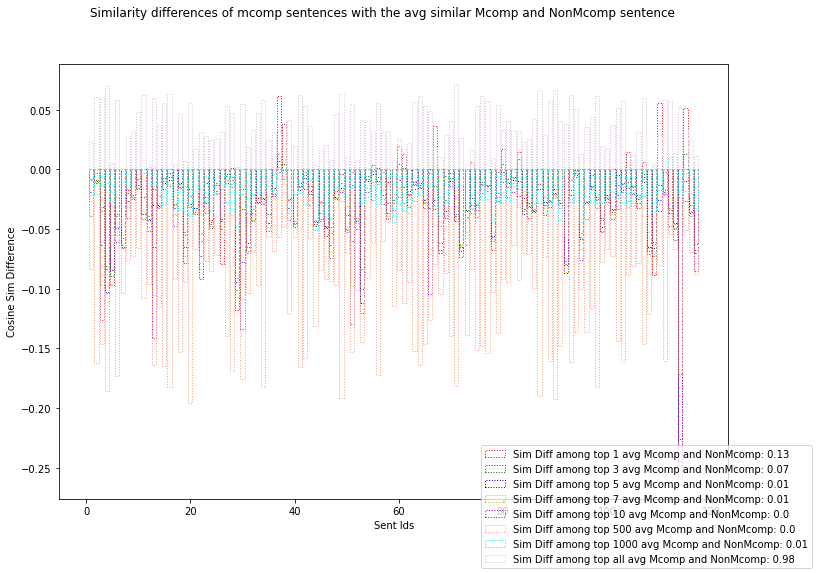

In [46]:
fig, axs = plt.subplots(1, 1, sharey=True, figsize=(12,8))
cols = ['r', 'g', 'b', 'y', 'm', 'lightsalmon', 'aqua', 'thistle']
cols_idx = 0

# for mean_of_k in ["all", "10", "20", "50", "100", "500", "1000", "1380"]: #+ mean_at_k:
for mean_of_k in ["1", "3", "5", "7", "10", "500", "1000", "all"]:
    v1 = round(sum(i > 0 for i in diff12[mean_of_k])/len(diff12[mean_of_k]), 2)
    rects1 = axs.bar(list(range(1,len(diff12[mean_of_k])+1)), diff12[mean_of_k], fill=False, 
                     edgecolor=cols[cols_idx], linestyle='dotted',
                     label="Sim Diff among top {} avg Mcomp and NonMcomp: {}".format(mean_of_k, v1))
    cols_idx += 1


fig.suptitle("Similarity differences of mcomp sentences with the avg similar Mcomp and NonMcomp sentence")

handles, labels = axs.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right')

plt.setp(axs, xlabel="Sent Ids", ylabel="Cosine Sim Difference")


# --------------------------------------------------------------------------------------------------------------

In [165]:
# NEW - diff13
 
res_table = [[""] + mean_at_k, [""]]

for val in mean_at_k:
#     print(sum(i > 0 for i in diff12[val]), len(diff12[val]))
    v1 = round(sum(i > 0 for i in diff13[val])/len(diff13[val]), 2)
    res_table[1].append(v1)

display(HTML(tabulate.tabulate(res_table, tablefmt='html')))

,1,3,5,7,10,20,30,50,100,500,1000,1380
,0.95,0.95,0.96,0.97,0.97,0.98,0.98,0.99,0.94,0.87,0.87,0.87


In [124]:
# NEW - diff12

res_table = [[""] + mean_at_k, [""]]

for val in mean_at_k:
#     print(sum(i > 0 for i in diff12[val]), len(diff12[val]))
    v1 = round(sum(i > 0 for i in diff12[val])/len(diff12[val]), 2)
    res_table[1].append(v1)

display(HTML(tabulate.tabulate(res_table, tablefmt='html')))

,1,3,5,7,10,20,30,50,100,500,1000,1380
,0.85,0.83,0.83,0.83,0.83,0.81,0.79,0.74,0.65,0.73,0.8,0.92


In [129]:
# OLD

res_table = [[""] + mean_at_k, [""]]

for val in mean_at_k:
    v1 = round(sum(i > 0 for i in diff12[val])/len(diff12[val]), 2)
    res_table[1].append(v1)

display(HTML(tabulate.tabulate(res_table, tablefmt='html')))

,1,3,5,7,10,20,30,50,100,500,1000,1380
,0.36,0.32,0.29,0.25,0.21,0.1,0.03,0,0,0.06,0.79,1


# B. With dataset

In [138]:
roberta_vectors = defaultdict(dict)
skip_uids = []

for pid in gt_dict:
    roberta_vectors[pid] = {}
    
    for mcs in gt_dict[pid]["mcomp"]:
        try:
            masked_sent = mask_entities_materials(df.loc[mcs]["Sent"]) #NEW
            #masked_sent = df.loc[mcs]["Sent"] #OLD
            vec = embed_text_using_roberta(masked_sent).mean(1).detach().numpy()
            roberta_vectors[pid][mcs] = vec / norm(vec)
        except Exception as ex:
            print(pid, mcs, df.loc[mcs]["Sent"])
            skip_uids.append(mcs)
    
    for mcs in gt_dict[pid]["not_mcomp"]:
        try:
            masked_sent = mask_entities_materials(df.loc[mcs]["Sent"]) #NEW
            #masked_sent = df.loc[mcs]["Sent"] #OLD
            vec = embed_text_using_roberta(masked_sent).mean(1).detach().numpy()
            roberta_vectors[pid][mcs] = vec / norm(vec)
        except Exception as ex:
            print(pid, mcs, df.loc[mcs]["Sent"])
            skip_uids.append(mcs)
        

2019_HyVxPsC9tm 938 2
2019_HyVxPsC9tm 940 3
2018_HyHmGyZCZ 1425 2


In [139]:
mcomp_sentences = {}
not_mcomp_sentences = {}

for pid in gt_dict:
    for mcs in gt_dict[pid]["mcomp"]:
        if not mcs in skip_uids:
            mcomp_sentences[mcs] = pid
    for mcs in gt_dict[pid]["not_mcomp"]:
        if not mcs in skip_uids:
            not_mcomp_sentences[mcs] = pid
print(len(mcomp_sentences), len(not_mcomp_sentences))

117 1385


In [140]:
sim_with_mcomp = defaultdict(dict)
sim_with_not_mcomp = defaultdict(dict)
sim_with_notmcomp_paper_sents = defaultdict(dict)

mean_at_k = ["1", "3", "5", "7", "10", "20", "30", "50", "100", "500", "1000", "1380"]

for sid in mcomp_sentences:
    
    # 1. With other mcomp sentences
    temp_list = []    
    for osid in mcomp_sentences:
        if osid != sid:
            temp_list.append(np.inner(roberta_vectors[mcomp_sentences[osid]][osid], roberta_vectors[mcomp_sentences[sid]][sid])[0][0])
    
    sorted_temp_list = sorted(temp_list, reverse=True)
    sim_with_mcomp[sid]["mean"] = np.mean(sorted_temp_list)
    for vv in mean_at_k:
        sim_with_mcomp[sid]["mean_{}".format(vv)] = np.mean(sorted_temp_list[0:int(vv)])

    
    # 2. With other not_mcomp_sentences
    temp_list = []
    for osid in not_mcomp_sentences:
        temp_list.append(np.inner(roberta_vectors[not_mcomp_sentences[osid]][osid], roberta_vectors[mcomp_sentences[sid]][sid])[0][0])
    
    sorted_temp_list = sorted(temp_list, reverse=True)
    sim_with_not_mcomp[sid]["mean"] = np.mean(sorted_temp_list)
    for vv in mean_at_k:
        sim_with_not_mcomp[sid]["mean_{}".format(vv)] = np.mean(sorted_temp_list[0:int(vv)])

    
    # 3. With not_mcomp_sentences of the same paper
    temp_list = []    
    for osid in not_mcomp_sentences:
        if not_mcomp_sentences[osid] == mcomp_sentences[sid]:
            temp_list.append(np.inner(roberta_vectors[not_mcomp_sentences[osid]][osid], roberta_vectors[mcomp_sentences[sid]][sid])[0][0])
    
    sorted_temp_list = sorted(temp_list, reverse=True)
    sim_with_notmcomp_paper_sents[sid]["mean"] = np.mean(sorted_temp_list)
    for vv in mean_at_k:
        sim_with_notmcomp_paper_sents[sid]["mean_{}".format(vv)] = np.mean(sorted_temp_list[0:int(vv)])
    

In [141]:
# mean_sim_plot
diff12 = {"all": []}
for vv in mean_at_k:
    diff12[str(vv)] = []

diff13 = {"all": []}
for vv in mean_at_k:
    diff13[str(vv)] = []

for sid in sim_with_mcomp:
    diff12["all"].append(sim_with_mcomp[sid]["mean"] - sim_with_not_mcomp[sid]["mean"])
    diff13["all"].append(sim_with_mcomp[sid]["mean"] - sim_with_notmcomp_paper_sents[sid]["mean"])
    
    for vv in mean_at_k:
        diff12[str(vv)].append(sim_with_mcomp[sid]["mean_{}".format(vv)] - sim_with_not_mcomp[sid]["mean_{}".format(vv)])
        diff13[str(vv)].append(sim_with_mcomp[sid]["mean_{}".format(vv)] - sim_with_notmcomp_paper_sents[sid]["mean_{}".format(vv)])


In [142]:
# NEW

res_table = [[""] + mean_at_k, [""]]

for val in mean_at_k:
    v1 = round(sum(i > 0 for i in diff12[val])/len(diff12[val]), 2)
    res_table[1].append(v1)

display(HTML(tabulate.tabulate(res_table, tablefmt='html')))

,1,3,5,7,10,20,30,50,100,500,1000,1380
,0.16,0.07,0.03,0.01,0,0,0,0,0,0,0.04,0.99


# 2. Entities masked with chunks

In [143]:
nlp = spacy.load('en_core_web_sm')
sp_toks = ["result", "method", "task", "dataset", "metric", "material"]

In [92]:
# def mask_entities(sentence):
#     cleaned_sent = re.sub('[^0-9a-zA-Z ]+', ' ', sentence)
#     while cleaned_sent.find("  ") > -1:
#         cleaned_sent = cleaned_sent.replace("  ", " ")
#     #print(cleaned_sent)
#     for i in entity_key_map:
#         if cleaned_sent.find(" " + i + " ") > -1:
#             #print("Substituting ent: {} with mask: {}".format(i, entity_dict[entity_key_map[i]].lower()))
#             cleaned_sent = cleaned_sent.replace(i, entity_dict[entity_key_map[i]].lower())
#     return cleaned_sent

In [151]:
def extract_chunks_using_spacy_dp(conssentence):
    
    conssentence = mask_entities_materials(conssentence)
#     print(conssentence)
    doc = nlp(conssentence)
    verb_subtree = []

    for s in doc.sents:
        find_special_tokens = {"compar": [], "result": [], "method": [], "task": [], "dataset": [], "material": [], "metric": []}

        for tok in s:

            if tok.text.lower().startswith("compar"):
                find_special_tokens["compar"].append(tok)
            else:
                for k in sp_toks:
                    if tok.text.lower().startswith(k):
                        find_special_tokens[k].append(tok)
                        break

        verb_tokens = []
        if find_special_tokens["compar"]:
            for t in find_special_tokens["compar"]:
#                     verb_subtree.append(t.subtree)
                if t == s.root:
                    simplified_sent = ""
                    for chh in t.lefts:
                        simplified_sent = simplified_sent + " " + chh.text
                    simplified_sent = simplified_sent + " " + t.text
                    for chh in t.rights:
                        simplified_sent = simplified_sent + " " + chh.text
#                         print("SIMP: ", simplified_sent)
                    verb_subtree.append(simplified_sent)
                else:
                    verb_subtree.append(t.subtree)
        else:
            for k in sp_toks:
                for i in find_special_tokens[k]:
                    local_vt = []
                    for j in i.ancestors:
                        if j.pos_ == "NOUN":
                            local_vt.append(j)
                    if not local_vt:
                        for j in i.ancestors:
                            if j.pos_ == "VERB":
                                local_vt.append(j)
                    verb_tokens = verb_tokens + local_vt


            for i in verb_tokens:
                verb_subtree.append(i.subtree)

#     print("Original Sentence: ", conssentence)
#     print("Verb SubTrees: ")
#     for i in verb_subtree:
#         print(i)
#         if type(i) == str:
#             print(i)
#         else:
#             for k in i:
#                 print(k, end=" ")
#         print("\n")
#     print("\n==============================================================================\n")
    eecc = []
    for i in verb_subtree:
        if type(i) == str:
            eecc.append(i)
        else:
            local_chunk = ""
            for lcaltok in i:
                local_chunk = local_chunk + " " + lcaltok.text
            eecc.append(local_chunk)
#     if not eecc:
#         print(conssentence)
    return list(set(eecc))


In [152]:
extract_chunks_using_spacy_dp("It would be interesting to explore the practicability of the method on more large-scale experiments on image related tasks.")

[' the practicability of the method',
 ' task related task',
 ' more large task experiments on task related task']

In [153]:
extract_chunks_using_spacy_dp("The experimental validation is also not extensive since comparison to SOTA is not included.")

[' compartaskon to SOTA task']

In [154]:
roberta_vectors = defaultdict(dict)
skip_uids = []

for pid in gt_dict:
    roberta_vectors[pid] = {}
    
    for mcs in gt_dict[pid]["mcomp"]:
#         mcomp_chunks_from_sent = extract_chunks_using_spacy_dp(df.loc[mcs]["Sent"])
#         final_chunk = ". ".join(mcomp_chunks_from_sent)
#         print(mcomp_chunks_from_sent, flush=True)

#         vec = embed_text_using_roberta(final_chunk.strip()).mean(1).detach().numpy()
#         roberta_vectors[pid][mcs] = vec / norm(vec)
        try:
            mcomp_chunks_from_sent = extract_chunks_using_spacy_dp(df.loc[mcs]["Sent"])
            if mcomp_chunks_from_sent:
                final_chunk = ". ".join(mcomp_chunks_from_sent)
            else:
                final_chunk = df.loc[mcs]["Sent"]
            
            vec = embed_text_using_roberta(final_chunk.strip()).mean(1).detach().numpy()
            roberta_vectors[pid][mcs] = vec / norm(vec)
        except Exception as ex:
            print(pid, mcs, df.loc[mcs]["Sent"])
            skip_uids.append(mcs)
    
    for mcs in gt_dict[pid]["not_mcomp"]:
        try:
            mcomp_chunks_from_sent = extract_chunks_using_spacy_dp(df.loc[mcs]["Sent"])
            if mcomp_chunks_from_sent:
                final_chunk = ". ".join(mcomp_chunks_from_sent)
            else:
                final_chunk = df.loc[mcs]["Sent"]
            
            vec = embed_text_using_roberta(final_chunk.strip()).mean(1).detach().numpy()
            roberta_vectors[pid][mcs] = vec / norm(vec)
        except Exception as ex:
            print(pid, mcs, df.loc[mcs]["Sent"])
            skip_uids.append(mcs)
        

2018_HkfXMz-Ab 554 Examples are given where appropriate in a clear and coherent manner
 • Problem statement well defined mathematically and understandable for a broad audience
 • Mentioning of failures and limitations demonstrates a realistic view on the project
 • Complexity and time analysis provided
 • Paper written so that it's easy for a reader to implement the methods
 • Detailed descriptions of all instantiations even parameters and comparison methods
 • System specified
 • Validation method specified
 • Data and repository, as well as cleaning process provided
 • Every figure and plot is well explained and interpreted
 • Large successful evaluation section provided
 • Many different evaluation measures defined to measure different properties of the project
 • Different observability modes
 • Evaluation against most compatible methods from other sources 
 • Results are in line with hypothesis
 • Thorough appendix clearing any open questions 
 
It would have been good to have a s

In [155]:
mcomp_sentences = {}
not_mcomp_sentences = {}

for pid in gt_dict:
    for mcs in gt_dict[pid]["mcomp"]:
        if not mcs in skip_uids:
            mcomp_sentences[mcs] = pid
    for mcs in gt_dict[pid]["not_mcomp"]:
        if not mcs in skip_uids:
            not_mcomp_sentences[mcs] = pid
print(len(mcomp_sentences), len(not_mcomp_sentences))

116 1384


In [156]:
sim_with_mcomp = defaultdict(dict)
sim_with_not_mcomp = defaultdict(dict)
sim_with_notmcomp_paper_sents = defaultdict(dict)

mean_at_k = ["1", "3", "5", "7", "10", "20", "30", "50", "100", "500", "1000", "1380"]

for sid in mcomp_sentences:
    
    # 1. With other mcomp sentences
    temp_list = []    
    for osid in mcomp_sentences:
        if osid != sid:
            temp_list.append(np.inner(roberta_vectors[mcomp_sentences[osid]][osid], roberta_vectors[mcomp_sentences[sid]][sid])[0][0])
    
    sorted_temp_list = sorted(temp_list, reverse=True)
    sim_with_mcomp[sid]["mean"] = np.mean(sorted_temp_list)
    for vv in mean_at_k:
        sim_with_mcomp[sid]["mean_{}".format(vv)] = np.mean(sorted_temp_list[0:int(vv)])

    
    # 2. With other not_mcomp_sentences
    temp_list = []
    for osid in not_mcomp_sentences:
        temp_list.append(np.inner(roberta_vectors[not_mcomp_sentences[osid]][osid], roberta_vectors[mcomp_sentences[sid]][sid])[0][0])
    
    sorted_temp_list = sorted(temp_list, reverse=True)
    sim_with_not_mcomp[sid]["mean"] = np.mean(sorted_temp_list)
    for vv in mean_at_k:
        sim_with_not_mcomp[sid]["mean_{}".format(vv)] = np.mean(sorted_temp_list[0:int(vv)])

    
    # 3. With not_mcomp_sentences of the same paper
    temp_list = []    
    for osid in not_mcomp_sentences:
        if not_mcomp_sentences[osid] == mcomp_sentences[sid]:
            temp_list.append(np.inner(roberta_vectors[not_mcomp_sentences[osid]][osid], roberta_vectors[mcomp_sentences[sid]][sid])[0][0])
    
    sorted_temp_list = sorted(temp_list, reverse=True)
    sim_with_notmcomp_paper_sents[sid]["mean"] = np.mean(sorted_temp_list)
    for vv in mean_at_k:
        sim_with_notmcomp_paper_sents[sid]["mean_{}".format(vv)] = np.mean(sorted_temp_list[0:int(vv)])
    

In [157]:
# mean_sim_plot
diff12 = {"all": []}
for vv in mean_at_k:
    diff12[str(vv)] = []

diff13 = {"all": []}
for vv in mean_at_k:
    diff13[str(vv)] = []

for sid in sim_with_mcomp:
    diff12["all"].append(sim_with_mcomp[sid]["mean"] - sim_with_not_mcomp[sid]["mean"])
    diff13["all"].append(sim_with_mcomp[sid]["mean"] - sim_with_notmcomp_paper_sents[sid]["mean"])
    
    for vv in mean_at_k:
        diff12[str(vv)].append(sim_with_mcomp[sid]["mean_{}".format(vv)] - sim_with_not_mcomp[sid]["mean_{}".format(vv)])
        diff13[str(vv)].append(sim_with_mcomp[sid]["mean_{}".format(vv)] - sim_with_notmcomp_paper_sents[sid]["mean_{}".format(vv)])


In [150]:
# With Materials as mask
res_table = [[""] + mean_at_k, [""]]

for val in mean_at_k:
    v1 = round(sum(i > 0 for i in diff12[val])/len(diff12[val]), 2)
    res_table[1].append(v1)

display(HTML(tabulate.tabulate(res_table, tablefmt='html')))

,1,3,5,7,10,20,30,50,100,500,1000,1380
,0.27,0.1,0.06,0.04,0.03,0,0,0,0,0,0.01,0.83


In [158]:
# WIth dataset as mask
res_table = [[""] + mean_at_k, [""]]

for val in mean_at_k:
    v1 = round(sum(i > 0 for i in diff12[val])/len(diff12[val]), 2)
    res_table[1].append(v1)

display(HTML(tabulate.tabulate(res_table, tablefmt='html')))

,1,3,5,7,10,20,30,50,100,500,1000,1380
,0.28,0.1,0.06,0.04,0.03,0.01,0,0,0,0,0.02,0.84


# 3. With Materials as mask and "dataset" not included in speacial token

In [168]:
sp_toks = ["result", "method", "task", "metric", "material"]

def extract_chunks_using_spacy_dp_without_dataset(conssentence):
    
    conssentence = mask_entities_materials(conssentence)
#     print(conssentence)
    doc = nlp(conssentence)
    verb_subtree = []

    for s in doc.sents:
        find_special_tokens = {"compar": [], "result": [], "method": [], "task": [], "material": [], "metric": []}

        for tok in s:

            if tok.text.lower().startswith("compar"):
                find_special_tokens["compar"].append(tok)
            else:
                for k in sp_toks:
                    if tok.text.lower().startswith(k):
                        find_special_tokens[k].append(tok)
                        break

        verb_tokens = []
        if find_special_tokens["compar"]:
            for t in find_special_tokens["compar"]:
#                     verb_subtree.append(t.subtree)
                if t == s.root:
                    simplified_sent = ""
                    for chh in t.lefts:
                        simplified_sent = simplified_sent + " " + chh.text
                    simplified_sent = simplified_sent + " " + t.text
                    for chh in t.rights:
                        simplified_sent = simplified_sent + " " + chh.text
#                         print("SIMP: ", simplified_sent)
                    verb_subtree.append(simplified_sent)
                else:
                    verb_subtree.append(t.subtree)
        else:
            for k in sp_toks:
                for i in find_special_tokens[k]:
                    local_vt = []
                    for j in i.ancestors:
                        if j.pos_ == "NOUN":
                            local_vt.append(j)
                    if not local_vt:
                        for j in i.ancestors:
                            if j.pos_ == "VERB":
                                local_vt.append(j)
                    verb_tokens = verb_tokens + local_vt


            for i in verb_tokens:
                verb_subtree.append(i.subtree)

#     print("Original Sentence: ", conssentence)
#     print("Verb SubTrees: ")
#     for i in verb_subtree:
#         print(i)
#         if type(i) == str:
#             print(i)
#         else:
#             for k in i:
#                 print(k, end=" ")
#         print("\n")
#     print("\n==============================================================================\n")
    eecc = []
    for i in verb_subtree:
        if type(i) == str:
            eecc.append(i)
        else:
            local_chunk = ""
            for lcaltok in i:
                local_chunk = local_chunk + " " + lcaltok.text
            eecc.append(local_chunk)
#     if not eecc:
#         print(conssentence)
    return list(set(eecc))


In [169]:
roberta_vectors = defaultdict(dict)
skip_uids = []

for pid in gt_dict:
    roberta_vectors[pid] = {}
    
    for mcs in gt_dict[pid]["mcomp"]:
        try:
            mcomp_chunks_from_sent = extract_chunks_using_spacy_dp_without_dataset(df.loc[mcs]["Sent"])
            if mcomp_chunks_from_sent:
                final_chunk = ". ".join(mcomp_chunks_from_sent)
            else:
                final_chunk = df.loc[mcs]["Sent"]
            
            vec = embed_text_using_roberta(final_chunk.strip()).mean(1).detach().numpy()
            roberta_vectors[pid][mcs] = vec / norm(vec)
        except Exception as ex:
            print(pid, mcs, df.loc[mcs]["Sent"])
            skip_uids.append(mcs)
    
    for mcs in gt_dict[pid]["not_mcomp"]:
        try:
            mcomp_chunks_from_sent = extract_chunks_using_spacy_dp_without_dataset(df.loc[mcs]["Sent"])
            if mcomp_chunks_from_sent:
                final_chunk = ". ".join(mcomp_chunks_from_sent)
            else:
                final_chunk = df.loc[mcs]["Sent"]
            
            vec = embed_text_using_roberta(final_chunk.strip()).mean(1).detach().numpy()
            roberta_vectors[pid][mcs] = vec / norm(vec)
        except Exception as ex:
            print(pid, mcs, df.loc[mcs]["Sent"])
            skip_uids.append(mcs)
        

2018_HkfXMz-Ab 554 Examples are given where appropriate in a clear and coherent manner
 • Problem statement well defined mathematically and understandable for a broad audience
 • Mentioning of failures and limitations demonstrates a realistic view on the project
 • Complexity and time analysis provided
 • Paper written so that it's easy for a reader to implement the methods
 • Detailed descriptions of all instantiations even parameters and comparison methods
 • System specified
 • Validation method specified
 • Data and repository, as well as cleaning process provided
 • Every figure and plot is well explained and interpreted
 • Large successful evaluation section provided
 • Many different evaluation measures defined to measure different properties of the project
 • Different observability modes
 • Evaluation against most compatible methods from other sources 
 • Results are in line with hypothesis
 • Thorough appendix clearing any open questions 
 
It would have been good to have a s

In [170]:
mcomp_sentences = {}
not_mcomp_sentences = {}

for pid in gt_dict:
    for mcs in gt_dict[pid]["mcomp"]:
        if not mcs in skip_uids:
            mcomp_sentences[mcs] = pid
    for mcs in gt_dict[pid]["not_mcomp"]:
        if not mcs in skip_uids:
            not_mcomp_sentences[mcs] = pid
print(len(mcomp_sentences), len(not_mcomp_sentences))

116 1384


In [171]:
sim_with_mcomp = defaultdict(dict)
sim_with_not_mcomp = defaultdict(dict)
sim_with_notmcomp_paper_sents = defaultdict(dict)

mean_at_k = ["1", "3", "5", "7", "10", "20", "30", "50", "100", "500", "1000", "1380"]

for sid in mcomp_sentences:
    
    # 1. With other mcomp sentences
    temp_list = []    
    for osid in mcomp_sentences:
        if osid != sid:
            temp_list.append(np.inner(roberta_vectors[mcomp_sentences[osid]][osid], roberta_vectors[mcomp_sentences[sid]][sid])[0][0])
    
    sorted_temp_list = sorted(temp_list, reverse=True)
    sim_with_mcomp[sid]["mean"] = np.mean(sorted_temp_list)
    for vv in mean_at_k:
        sim_with_mcomp[sid]["mean_{}".format(vv)] = np.mean(sorted_temp_list[0:int(vv)])

    
    # 2. With other not_mcomp_sentences
    temp_list = []
    for osid in not_mcomp_sentences:
        temp_list.append(np.inner(roberta_vectors[not_mcomp_sentences[osid]][osid], roberta_vectors[mcomp_sentences[sid]][sid])[0][0])
    
    sorted_temp_list = sorted(temp_list, reverse=True)
    sim_with_not_mcomp[sid]["mean"] = np.mean(sorted_temp_list)
    for vv in mean_at_k:
        sim_with_not_mcomp[sid]["mean_{}".format(vv)] = np.mean(sorted_temp_list[0:int(vv)])

    
    # 3. With not_mcomp_sentences of the same paper
    temp_list = []    
    for osid in not_mcomp_sentences:
        if not_mcomp_sentences[osid] == mcomp_sentences[sid]:
            temp_list.append(np.inner(roberta_vectors[not_mcomp_sentences[osid]][osid], roberta_vectors[mcomp_sentences[sid]][sid])[0][0])
    
    sorted_temp_list = sorted(temp_list, reverse=True)
    sim_with_notmcomp_paper_sents[sid]["mean"] = np.mean(sorted_temp_list)
    for vv in mean_at_k:
        sim_with_notmcomp_paper_sents[sid]["mean_{}".format(vv)] = np.mean(sorted_temp_list[0:int(vv)])
    

In [172]:
# mean_sim_plot
diff12 = {"all": []}
for vv in mean_at_k:
    diff12[str(vv)] = []

diff13 = {"all": []}
for vv in mean_at_k:
    diff13[str(vv)] = []

for sid in sim_with_mcomp:
    diff12["all"].append(sim_with_mcomp[sid]["mean"] - sim_with_not_mcomp[sid]["mean"])
    diff13["all"].append(sim_with_mcomp[sid]["mean"] - sim_with_notmcomp_paper_sents[sid]["mean"])
    
    for vv in mean_at_k:
        diff12[str(vv)].append(sim_with_mcomp[sid]["mean_{}".format(vv)] - sim_with_not_mcomp[sid]["mean_{}".format(vv)])
        diff13[str(vv)].append(sim_with_mcomp[sid]["mean_{}".format(vv)] - sim_with_notmcomp_paper_sents[sid]["mean_{}".format(vv)])


In [173]:
# With Materials as mask and "dataset" not included in speacial token
res_table = [[""] + mean_at_k, [""]]

for val in mean_at_k:
    v1 = round(sum(i > 0 for i in diff12[val])/len(diff12[val]), 2)
    res_table[1].append(v1)

display(HTML(tabulate.tabulate(res_table, tablefmt='html')))

,1,3,5,7,10,20,30,50,100,500,1000,1380
,0.24,0.09,0.05,0.03,0.02,0,0,0,0,0,0.01,0.85


### Plot

In [99]:
sim_with_mcomp[sid], sim_with_not_mcomp[sid]

({'mean': 0.35703406,
  'mean_1': 0.7115663,
  'mean_3': 0.662719,
  'mean_5': 0.61468875,
  'mean_7': 0.5833015,
  'mean_10': 0.55300343,
  'mean_20': 0.49535513,
  'mean_30': 0.46681887,
  'mean_50': 0.4295041,
  'mean_100': 0.3729767,
  'mean_500': 0.35703406,
  'mean_1000': 0.35703406,
  'mean_1380': 0.35703406},
 {'mean': 0.34860045,
  'mean_1': 0.7782862,
  'mean_3': 0.7350459,
  'mean_5': 0.7124306,
  'mean_7': 0.698928,
  'mean_10': 0.68746746,
  'mean_20': 0.65732706,
  'mean_30': 0.62639165,
  'mean_50': 0.5866736,
  'mean_100': 0.5368412,
  'mean_500': 0.43195587,
  'mean_1000': 0.38228405,
  'mean_1380': 0.3491686})

In [100]:
# mean_sim_plot
diff12 = {"all": []}
for vv in mean_at_k:
    diff12[str(vv)] = []

diff13 = {"all": []}
for vv in mean_at_k:
    diff13[str(vv)] = []

for sid in sim_with_mcomp:
    diff12["all"].append(sim_with_mcomp[sid]["mean"] - sim_with_not_mcomp[sid]["mean"])
    diff13["all"].append(sim_with_mcomp[sid]["mean"] - sim_with_notmcomp_paper_sents[sid]["mean"])
    
    for vv in mean_at_k:
        diff12[str(vv)].append(sim_with_mcomp[sid]["mean_{}".format(vv)] - sim_with_not_mcomp[sid]["mean_{}".format(vv)])
        diff13[str(vv)].append(sim_with_mcomp[sid]["mean_{}".format(vv)] - sim_with_notmcomp_paper_sents[sid]["mean_{}".format(vv)])


In [101]:
mean_at_k

['1', '3', '5', '7', '10', '20', '30', '50', '100', '500', '1000', '1380']

In [102]:
res_table = [[""] + mean_at_k, [""]]

for val in mean_at_k:
    v1 = round(sum(i > 0 for i in diff12[val])/len(diff12[val]), 2)
    res_table[1].append(v1)

display(HTML(tabulate.tabulate(res_table, tablefmt='html')))

,1,3,5,7,10,20,30,50,100,500,1000,1380
,0.28,0.1,0.07,0.03,0.03,0,0,0,0,0,0.01,0.83


In [103]:
res_table

[['',
  '1',
  '3',
  '5',
  '7',
  '10',
  '20',
  '30',
  '50',
  '100',
  '500',
  '1000',
  '1380'],
 ['', 0.28, 0.1, 0.07, 0.03, 0.03, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01, 0.83]]

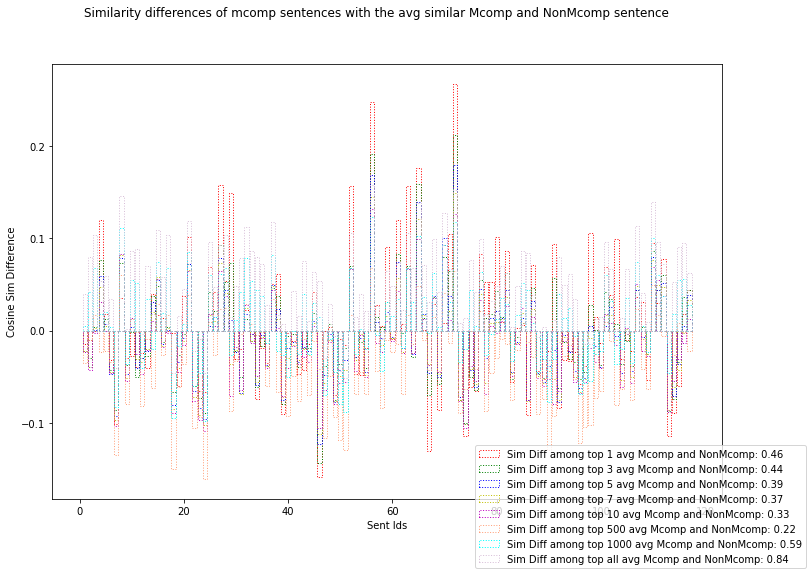

In [86]:
fig, axs = plt.subplots(1, 1, sharey=True, figsize=(12,8))
cols = ['r', 'g', 'b', 'y', 'm', 'lightsalmon', 'aqua', 'thistle']
cols_idx = 0

# for mean_of_k in ["all", "10", "20", "50", "100", "500", "1000", "1380"]: #+ mean_at_k:
for mean_of_k in ["1", "3", "5", "7", "10", "500", "1000", "all"]:
    v1 = round(sum(i > 0 for i in diff12[mean_of_k])/len(diff12[mean_of_k]), 2)
    rects1 = axs.bar(list(range(1,len(diff12[mean_of_k])+1)), diff12[mean_of_k], fill=False, 
                     edgecolor=cols[cols_idx], linestyle='dotted',
                     label="Sim Diff among top {} avg Mcomp and NonMcomp: {}".format(mean_of_k, v1))
    cols_idx += 1


fig.suptitle("Similarity differences of mcomp sentences with the avg similar Mcomp and NonMcomp sentence")

handles, labels = axs.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right')

plt.setp(axs, xlabel="Sent Ids", ylabel="Cosine Sim Difference")

plt.savefig('plots/mean_diff_roberta_at_ks_smallrange_FORCHUNKS.png', dpi=300)

In [87]:
res_table = [mean_at_k, []]

for val in mean_at_k:
    v1 = round(sum(i > 0 for i in diff13[val])/len(diff13[val]), 2)
    res_table[1].append(v1)

display(HTML(tabulate.tabulate(res_table, tablefmt='html')))

1,3,5,7,10,20,30,50,100,500,1000,1380
0.79,0.84,0.86,0.86,0.86,0.88,0.91,0.96,0.78,0.65,0.65,0.65


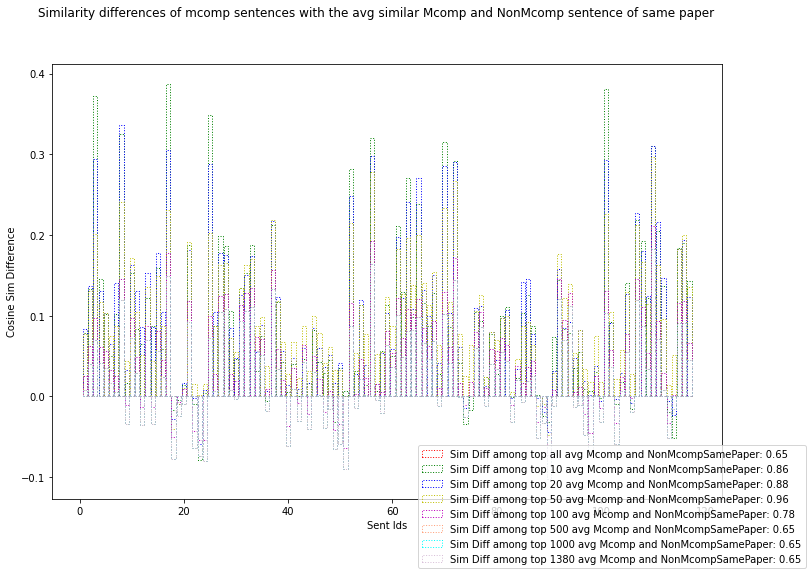

In [88]:
fig, axs = plt.subplots(1, 1, sharey=True, figsize=(12,8))
cols = ['r', 'g', 'b', 'y', 'm', 'lightsalmon', 'aqua', 'thistle']
cols_idx = 0

for mean_of_k in ["all", "10", "20", "50", "100", "500", "1000", "1380"]: #+ mean_at_k:
    v1 = round(sum(i > 0 for i in diff13[mean_of_k])/len(diff13[mean_of_k]), 2)
    rects1 = axs.bar(list(range(1,len(diff13[mean_of_k])+1)), diff13[mean_of_k], fill=False, 
                     edgecolor=cols[cols_idx], linestyle='dotted',
                     label="Sim Diff among top {} avg Mcomp and NonMcompSamePaper: {}".format(mean_of_k, v1))
    cols_idx += 1


fig.suptitle("Similarity differences of mcomp sentences with the avg similar Mcomp and NonMcomp sentence of same paper")

handles, labels = axs.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right')

plt.setp(axs, xlabel="Sent Ids", ylabel="Cosine Sim Difference")

plt.savefig('plots/mean_diff_roberta_at_ks_samepaper_FORCHUNKS.png', dpi=300)

### Analyse meaningful sentences that are more similar to NMCS in comparison to MCS.

In [89]:
ana_sim_with_mcomp = defaultdict(list)
ana_sim_with_not_mcomp = defaultdict(list)


mean_at_k = ["1", "3", "5", "7", "10", "20", "30", "50", "100", "500", "1000", "1380"]

for sid in mcomp_sentences:
    
    # 1. With other mcomp sentences
    temp_list = []    
    for osid in mcomp_sentences:
        if osid != sid:
            temp_list.append((osid, np.inner(roberta_vectors[mcomp_sentences[osid]][osid], roberta_vectors[mcomp_sentences[sid]][sid])[0][0]))
    
    sorted_temp_list = sorted(temp_list, key=lambda x: x[1], reverse=True)
    ana_sim_with_mcomp[sid] = sorted_temp_list

    
    # 2. With other not_mcomp_sentences
    temp_list = []
    for osid in not_mcomp_sentences:
        temp_list.append((osid, np.inner(roberta_vectors[not_mcomp_sentences[osid]][osid], roberta_vectors[mcomp_sentences[sid]][sid])[0][0]))
    
    sorted_temp_list = sorted(temp_list, key=lambda x: x[1], reverse=True)
    ana_sim_with_not_mcomp[sid] = sorted_temp_list

In [90]:
problematic_sentences_at_k = defaultdict(list)
unproblematic_sentences_at_k = defaultdict(list)
vv = 3

for sid in sim_with_mcomp:
    sim_diff = (sim_with_mcomp[sid]["mean_{}".format(vv)] - sim_with_not_mcomp[sid]["mean_{}".format(vv)])
    if sim_diff < 0:
        problematic_sentences_at_k[vv].append((sid,-1.0* sim_diff))
    else:
        unproblematic_sentences_at_k[vv].append((sid, sim_diff))

In [91]:
k = 3
sorted_problematic_sentences_at_3 = sorted(problematic_sentences_at_k[3], key=lambda x: x[1], reverse=True)
sorted(problematic_sentences_at_k[3], key=lambda x: x[1], reverse=True)[0:5]

[(657, 0.14322012662887573),
 (972, 0.1004522442817688),
 (271, 0.0893101692199707),
 (1504, 0.08690214157104492),
 (48, 0.08574169874191284)]

In [92]:
sorted_problematic_sentences_at_3[0:3], sorted_problematic_sentences_at_3[-3:]

([(657, 0.14322012662887573),
  (972, 0.1004522442817688),
  (271, 0.0893101692199707)],
 [(627, 0.00366133451461792),
  (873, 0.002418994903564453),
  (87, 0.0010606646537780762)])

In [93]:
sorted_unproblematic_sentences_at_3 = sorted(unproblematic_sentences_at_k[3], key=lambda x: x[1], reverse=True)
sorted_unproblematic_sentences_at_3[0:4], sorted_unproblematic_sentences_at_3[-4:]

([(919, 0.21184415), (834, 0.19087964), (884, 0.15892553), (312, 0.09217894)],
 [(1421, 0.0039582253),
  (20, 0.0035532713),
  (160, 0.0035532713),
  (1284, 0.00019001961)])

In [94]:
for s in sorted_problematic_sentences_at_3[0:5]:
    print("Test sent: ", df.loc[s[0]]["Sent"])
    #print("MComp Sentence under consideration: {} - {}".format(s[0], df.loc[s[0]]["Sent"]))
    
    print("\nMeaningful comparison sentences: ")
    print(ana_sim_with_mcomp[s[0]][0:3])
    for i in ana_sim_with_mcomp[s[0]][0:3]:
        print(df.loc[i[0]]["Sent"])
        #print("{}: {}".format(i[0], df.loc[i[0]]["Sent"]))
    
    print("\nNon Meaningful comparison sentence: ")
    print(ana_sim_with_not_mcomp[s[0]][0:3])
    for i in ana_sim_with_not_mcomp[s[0]][0:3]:
        print(df.loc[i[0]]["Sent"])
        #print("{}: {}".format(i[0], df.loc[i[0]]["Sent"]))
    
    print("\n\n")

Test sent:  (-) More than two datasets are necessary to show the effectiveness of the methods
comments)
- What is the higher level feature map P_m?

Meaningful comparison sentences: 
[(1079, 0.6937835), (39, 0.6450732), (443, 0.625373)]
- For reference, please include wallclock time and actual overall memory consumption comparisons of the proposed methods and other methods as well as the baseline (default FP32 training).
It would be interesting to explore the practicability of the method on more large-scale experiments on image related tasks.
Several different encoding benchmarks of the entailment task are designed to compare against the performance of the proposed model, using a newly created dataset.

Non Meaningful comparison sentence: 
[(864, 0.85275584), (1254, 0.7734018), (1257, 0.7677325)]
However, the included experiments are not nearly sufficient to establish the effectiveness of the proposed method.
The clarifications with respect to related works and missing references is he